
# 3D Beamforming with CLEAN-SC deconvolution.

Demonstrates a 3D beamforming setup with simulated point sources.
Simulates data on 64 channel array, subsequent beamforming with CLEAN-SC on 3D grid.


In [58]:
from pathlib import Path

import acoular as ac
import numpy as np

First, we define the microphone geometry.



In [59]:
# micgeofile = Path(ac.__file__).parent / 'xml' / 'array_64.xml'
micgeofile = Path().resolve() / "bassoon_cage.xml"
m = ac.MicGeom(from_file=micgeofile)

Now, the sources (signals and types/positions) are defined.



In [60]:
sfreq = 51200
duration = 1
nsamples = duration * sfreq

n1 = ac.WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples, seed=1)
n2 = ac.WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples, seed=2, rms=0.5)
n3 = ac.WNoiseGenerator(sample_freq=sfreq, numsamples=nsamples, seed=3, rms=0.25)
p1 = ac.PointSource(signal=n1, mics=m, loc=(-0.1, -0.1, 0.3))
p2 = ac.PointSource(signal=n2, mics=m, loc=(0.15, 0, 0.17))
p3 = ac.PointSource(signal=n3, mics=m, loc=(0, 0.1, 0.25))
pa = ac.SourceMixer(sources=[p1, p2, p3])

Next, the 3D grid defining the source region is set up (very coarse to enable fast computation for this example)



In [61]:
g = ac.RectGrid3D(x_min=-0.2, x_max=0.2, y_min=-0.2, y_max=0.2, z_min=0.1, z_max=0.36, increment=0.002)

The following provides the cross spectral matrix and defines the CLEAN-SC beamformer.



In [62]:
f = ac.PowerSpectra(source=pa, window='Hanning', overlap='50%', block_size=256)#128)
st = ac.SteeringVector(grid=g, mics=m, steer_type='true location')
b = ac.BeamformerCleansc(freq_data=f, steer=st)

Calculate the result for 4 kHz octave band. The result will automatically be cached to disk.
By default, the corresponding cache file is located in the cache directory of the current working directory.



In [63]:
map = b.synthetic(1000, 1)

[('SourceMixer_3ddf67f518139131bfd2f2a8927dc50b_cache.h5', 8)]
[('SourceMixer_3ddf67f518139131bfd2f2a8927dc50b_cache.h5', 9)]


Display views of setup and result.
For each view, the values along the repsective axis are summed.
Note that, while Acoular uses a left-oriented coordinate system,
for display purposes, the z-axis is inverted, plotting the data in
a right-oriented coordinate system.



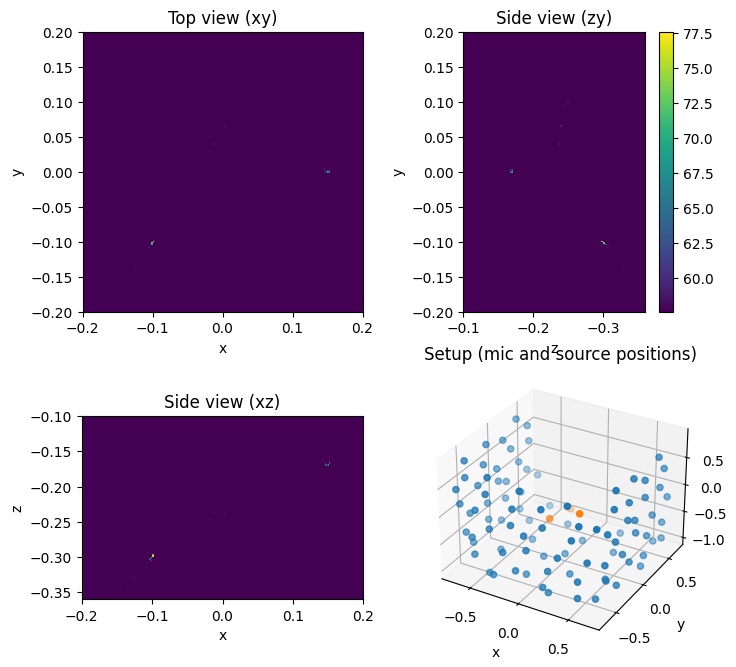

In [65]:
from pylab import colorbar, figure, imshow, show, subplot, title, xlabel, ylabel

fig = figure(1, (8, 8))

# plot the results

subplot(221)
map_z = np.sum(map, 2)
mx = ac.L_p(map_z.max())
imshow(
    ac.L_p(map_z.T),
    vmax=mx,
    vmin=mx - 20,
    origin='lower',
    interpolation='nearest',
    extent=(g.x_min, g.x_max, g.y_min, g.y_max),
)
xlabel('x')
ylabel('y')
title('Top view (xy)')

subplot(223)
map_y = np.sum(map, 1)
imshow(
    ac.L_p(map_y.T),
    vmax=mx,
    vmin=mx - 20,
    origin='upper',
    interpolation='nearest',
    extent=(g.x_min, g.x_max, -g.z_max, -g.z_min),
)
xlabel('x')
ylabel('z')
title('Side view (xz)')

subplot(222)
map_x = np.sum(map, 0)
imshow(
    ac.L_p(map_x),
    vmax=mx,
    vmin=mx - 20,
    origin='lower',
    interpolation='nearest',
    extent=(-g.z_min, -g.z_max, g.y_min, g.y_max),
)
xlabel('z')
ylabel('y')
title('Side view (zy)')
colorbar()

ax0 = fig.add_subplot((224), projection='3d')
ax0.scatter(m.mpos[0], m.mpos[1], -m.mpos[2])
source_locs = np.array([p1.loc, p2.loc, p3.loc]).T
ax0.scatter(source_locs[0], source_locs[1], -source_locs[2])
ax0.set_xlabel('x')
ax0.set_ylabel('y')
ax0.set_zlabel('z')
ax0.set_title('Setup (mic and source positions)')
show()